# Run & display stats

In [31]:
import gc
import os
import datetime
import numpy as np
from tqdm.notebook import tqdm

from sim import FunctionType, Simulation, StaticSimulation, SimulationResults, LinearSimulation, LinearSimulationStatic, LongstepSimulation, LongstepSimulationStatic, SimulationEnsemble
from graph import GraphType, CompleteGraph, RingGraph, RocGraph, ErGraph, CompleteGraph
from rw_utils import pickle_obj
from db import SimulationDatabase, SimulationDirectory

In [32]:
num_nodes = 500
nums_edges = [1100, 2300, 6020]
graph_types = [GraphType.ring, GraphType.roc, GraphType.er]

# (GraphType, num_edges): Graph
graphs = {
    # (GraphType.complete, 4950): (CompleteGraph, {'num_nodes': num_nodes}),
    (GraphType.ring, 1100): (RingGraph, {'num_nodes': num_nodes, 'degree': 4}),
    (GraphType.ring, 2300): (RingGraph, {'num_nodes': num_nodes, 'degree': 10}),
    (GraphType.ring, 6020): (RingGraph, {'num_nodes': num_nodes, 'degree': 24}),
    (GraphType.er, 1100): (ErGraph, {'num_nodes': num_nodes, 'num_edges': 1100}),
    (GraphType.er, 2300): (ErGraph, {'num_nodes': num_nodes, 'num_edges': 2300}),
    (GraphType.er, 6020): (ErGraph, {'num_nodes': num_nodes, 'num_edges': 6020}),
    (GraphType.roc, 1100): (RocGraph, {'num_cliques': 100, 'clique_size': 5}),
    (GraphType.roc, 2300): (RocGraph, {'num_cliques': 50, 'clique_size': 10})
    # (GraphType.roc, 6020): (RocGraph, {'num_cliques': 20, 'clique_size': 25})
}

# (FunctionType, static): Simulation
simulations = {
    (FunctionType.linear, False): LinearSimulation,
    (FunctionType.longstep, False): LongstepSimulation,
    (FunctionType.linear, True): LinearSimulationStatic,
    (FunctionType.longstep, True): LongstepSimulationStatic
}

In [33]:
num_runs = 5
params = {
    'graph': None,
    'eps': 0.1,
    'beta_0': 0.055,
    'beta_1': 0.050,
    'alpha_0': 0.0,
    'alpha_1': 0.0,
    'X': np.array([[.02, .98], [.02, .98]]),
    'max_num_iter': 150_000
}

## Run

Careful with parameters for `Longstep, RocGraph(4x25)` and `Longstep, RingGraph(100,24)`.

In [34]:
for (graph_type, num_edges), (graph_class, graph_params) in graphs.items():
    for (func_type, static), simulation_class in simulations.items():
        params['graph'] = graph_class(**graph_params)
        sim = simulation_class(**params)
        sim_ensemble = SimulationEnsemble(sim, num_runs)
        sim_ensemble.run()

LinearSimulation on ring(n=500,k=4) (1000 edges): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.50s/it]
LongstepSimulation on ring(n=500,k=4) (1000 edges): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.43s/it]
LinearSimulationStatic on ring(n=500,k=4) (1000 edges): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]
LongstepSimulationStatic on ring(n=500,k=4) (1000 edges): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]
LinearSimulation on ring(n=500,k=10) (2500 edges): 100%|████████████████████████████████████████████████████████████████████████████████████████████

## Display stats

In [12]:
sdb = SimulationDatabase(path='output')
for (graph_type, num_edges), (_, graph_params) in graphs.items():
    for (func_type, static), _ in simulations.items():
        sdirs = [
            sdir
            for sdir in sdb.sdirs
            if (sdir.sim.func_type == func_type) and
            (static is isinstance(sdir.sim, StaticSimulation)) and
            (num_edges - 200 <= sdir.sim.graph.graph.number_of_edges() <= num_edges + 200) and
            (sdir.sim.graph.graph_type == graph_type)
        ]
        if len(sdirs) != 1:
            raise RuntimeError(f"Found {len(sdirs)} SimulationDirectories after filter. Expected 1.")
        sdir = sdirs[0]
        
        sdir.cache()
        sdir.info()
        del sdir
        gc.collect()

SimulationDirectory for LinearSimulation on ring(n=500,k=4), 1000 edges (5 runs)
E[t|~A] = nan
E[t|A] = 22382.0
tmax = 29767
SimulationDirectory for LongstepSimulation on ring(n=500,k=4), 1000 edges (5 runs)
E[t|~A] = nan
E[t|A] = 23758.8
tmax = 64844
SimulationDirectory for LinearSimulationStatic on ring(n=500,k=4), 1000 edges (5 runs)
E[t|~A] = None
E[t|A] = 2383.8
tmax = 3431
SimulationDirectory for LongstepSimulationStatic on ring(n=500,k=4), 1000 edges (5 runs)
E[t|~A] = None
E[t|A] = 2446.8
tmax = 3124
SimulationDirectory for LinearSimulation on ring(n=500,k=10), 2500 edges (5 runs)
E[t|~A] = 1273.0
E[t|A] = 4398.25
tmax = 5103
SimulationDirectory for LongstepSimulation on ring(n=500,k=10), 2500 edges (5 runs)
E[t|~A] = nan
E[t|A] = 8141.4
tmax = 12765
SimulationDirectory for LinearSimulationStatic on ring(n=500,k=10), 2500 edges (5 runs)
E[t|~A] = None
E[t|A] = 897.6
tmax = 1281
SimulationDirectory for LongstepSimulationStatic on ring(n=500,k=10), 2500 edges (5 runs)
E[t|~A] = N

# Plot & animate

In [13]:
import os
import gc
import numpy as np
from matplotlib import pyplot as plt

from sim import FunctionType, StaticSimulation, FunctionType
from graph import GraphType, RingGraph, RocGraph, ErGraph
from plot import SigmaPlot
from db import SimulationDatabase, SimulationDirectory
from utils import sigma_mean, sigmas, pad
from rw_utils import read_pickled, deserialize_boolean_array
from animate import animate

%matplotlib inline

In [14]:
color = {
    GraphType.ring: 'red',
    GraphType.roc: 'green',
    GraphType.er: 'blue',
}

x_right = {
    FunctionType.linear: 2500,
    FunctionType.longstep: 25000
}

label = {
    GraphType.ring: 'k-рег. кольцо',
    GraphType.roc: 'кольцо клик',
    GraphType.er: 'ER',
}

## Plot all

linear_e1100.png:
caching SimulationDirectory for LinearSimulation on ring(n=500,k=4), 1000 edges (5 runs)...
caching SimulationDirectory for LinearSimulation on er(n=500,m=1100), 1100 edges (5 runs)...
caching SimulationDirectory for LinearSimulation on roc(k=100,l=5), 1100 edges (5 runs)...



F:\VKR\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


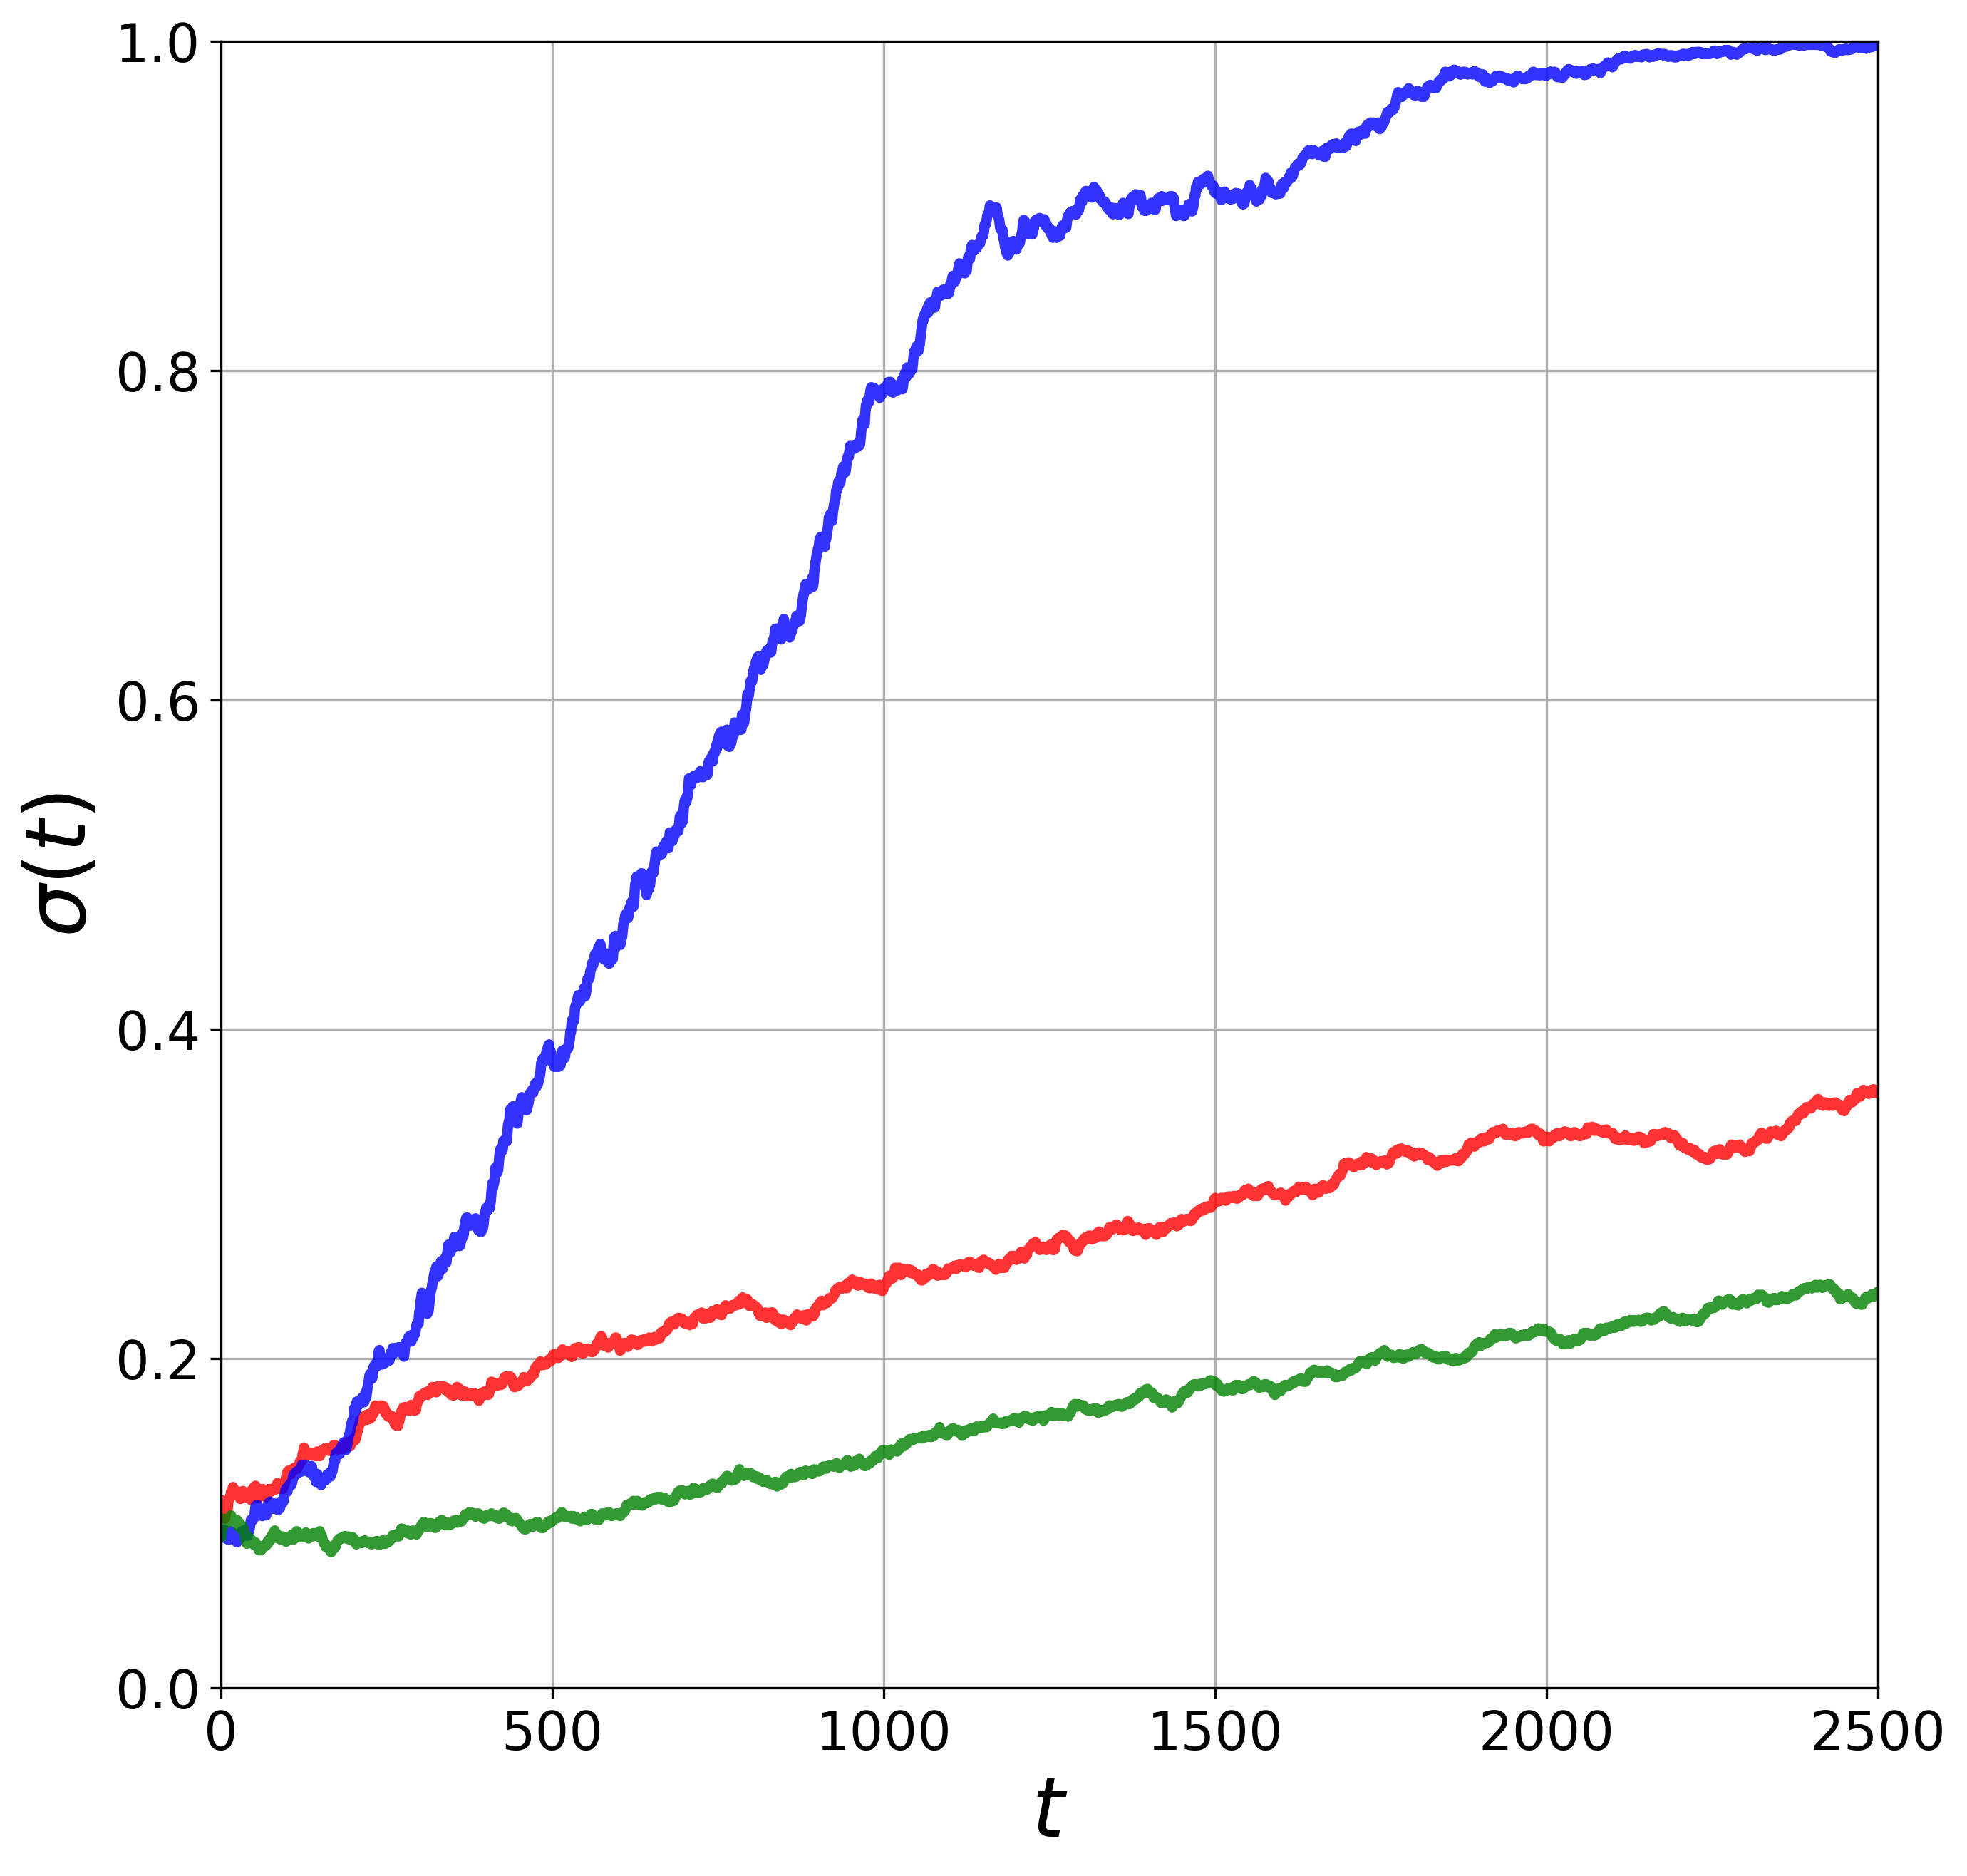

linear_e2300.png:
caching SimulationDirectory for LinearSimulation on ring(n=500,k=10), 2500 edges (5 runs)...
caching SimulationDirectory for LinearSimulation on er(n=500,m=2300), 2300 edges (5 runs)...
caching SimulationDirectory for LinearSimulation on roc(k=50,l=10), 2300 edges (5 runs)...



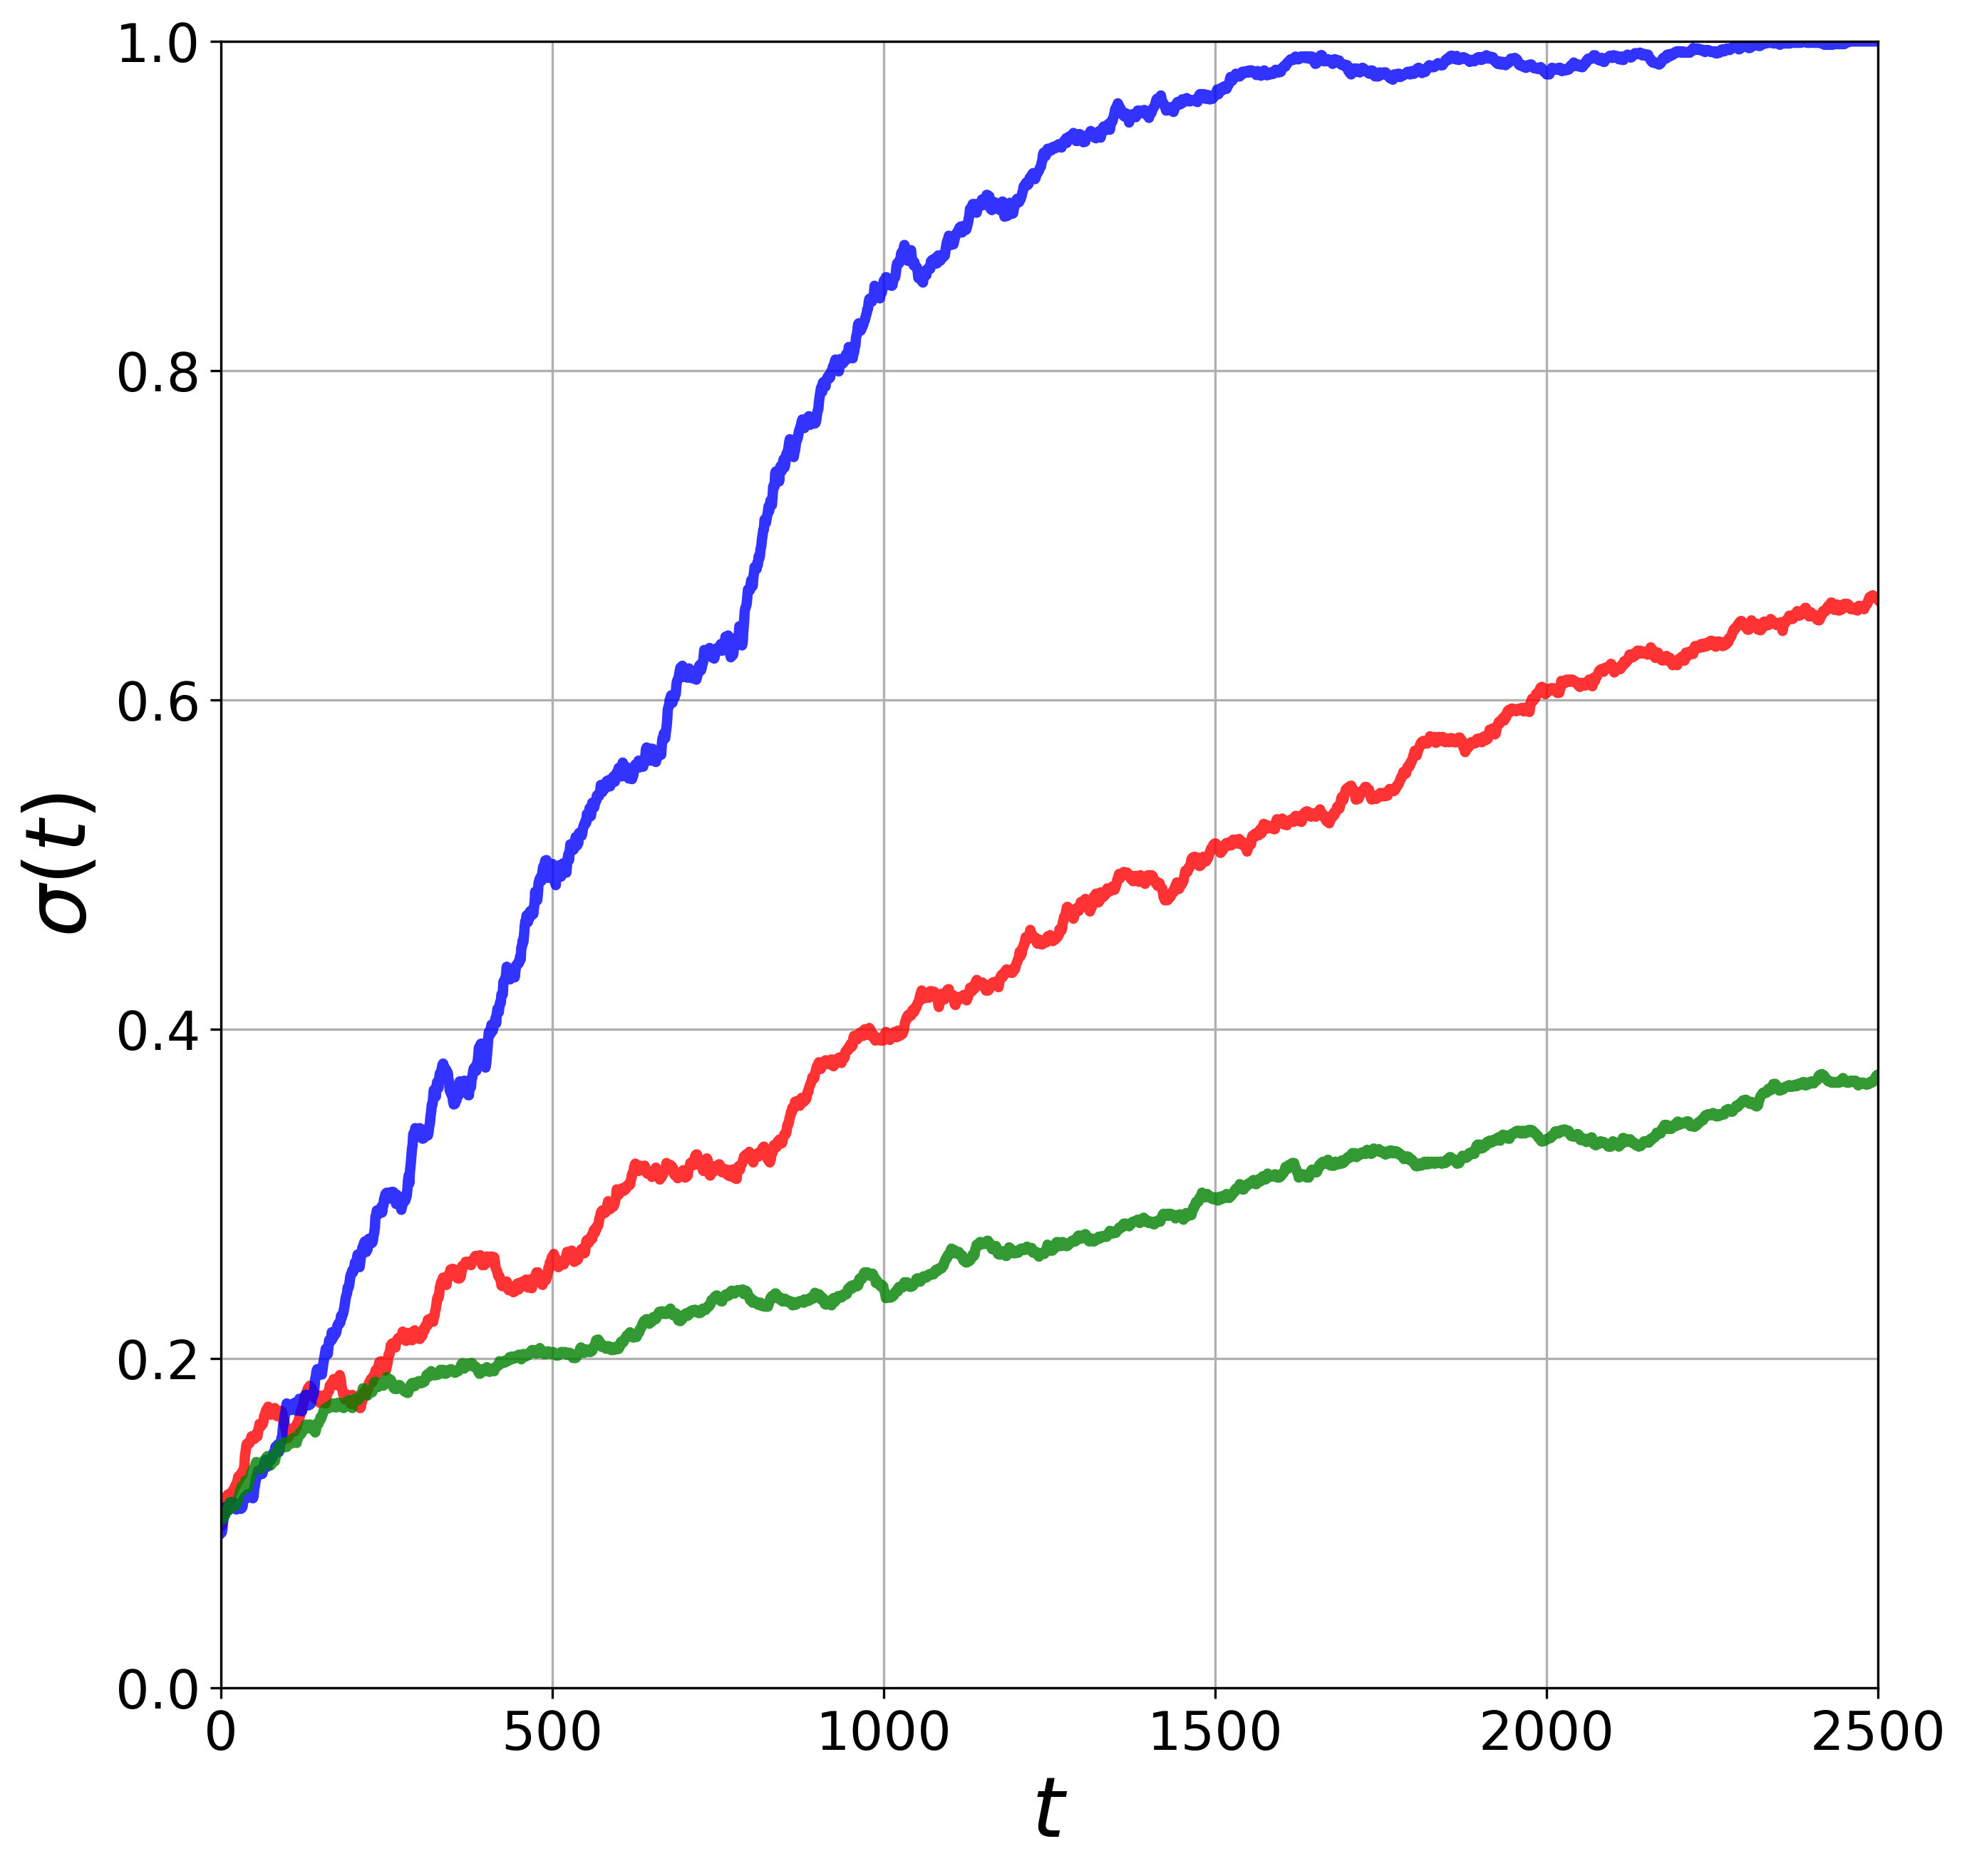

RuntimeError: Expected 3 SimulationDirectories after filter, got 2.

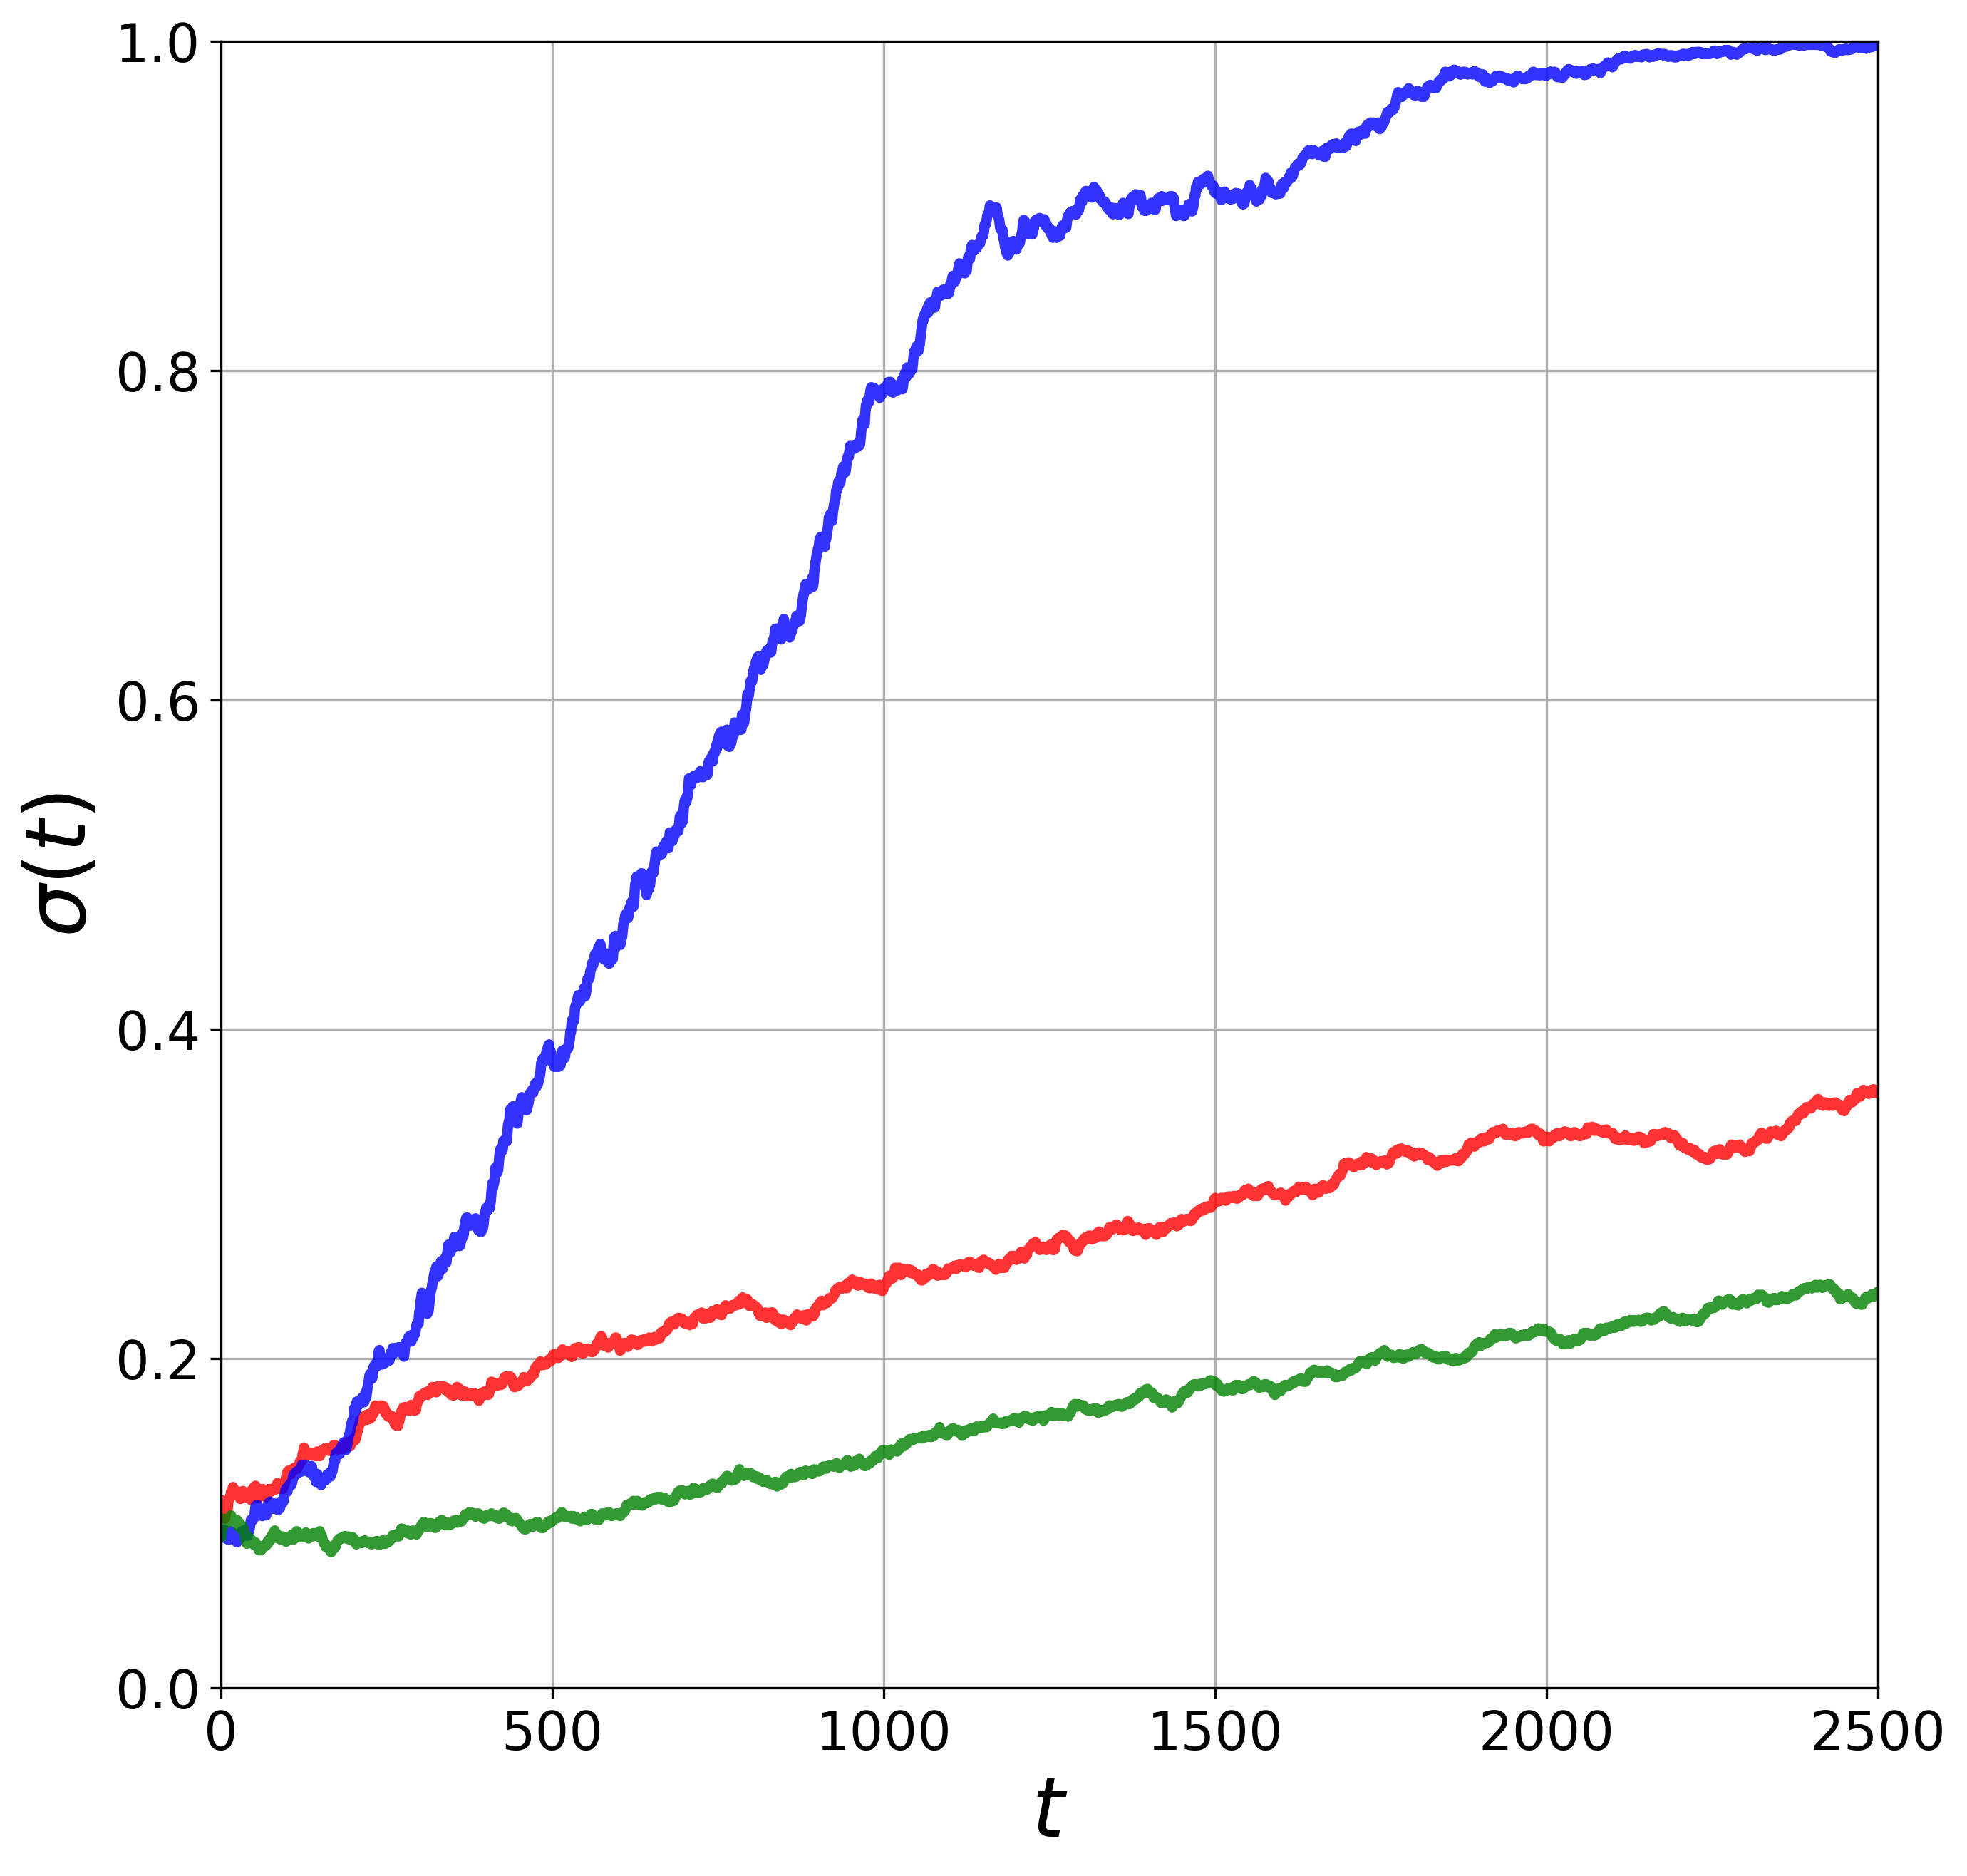

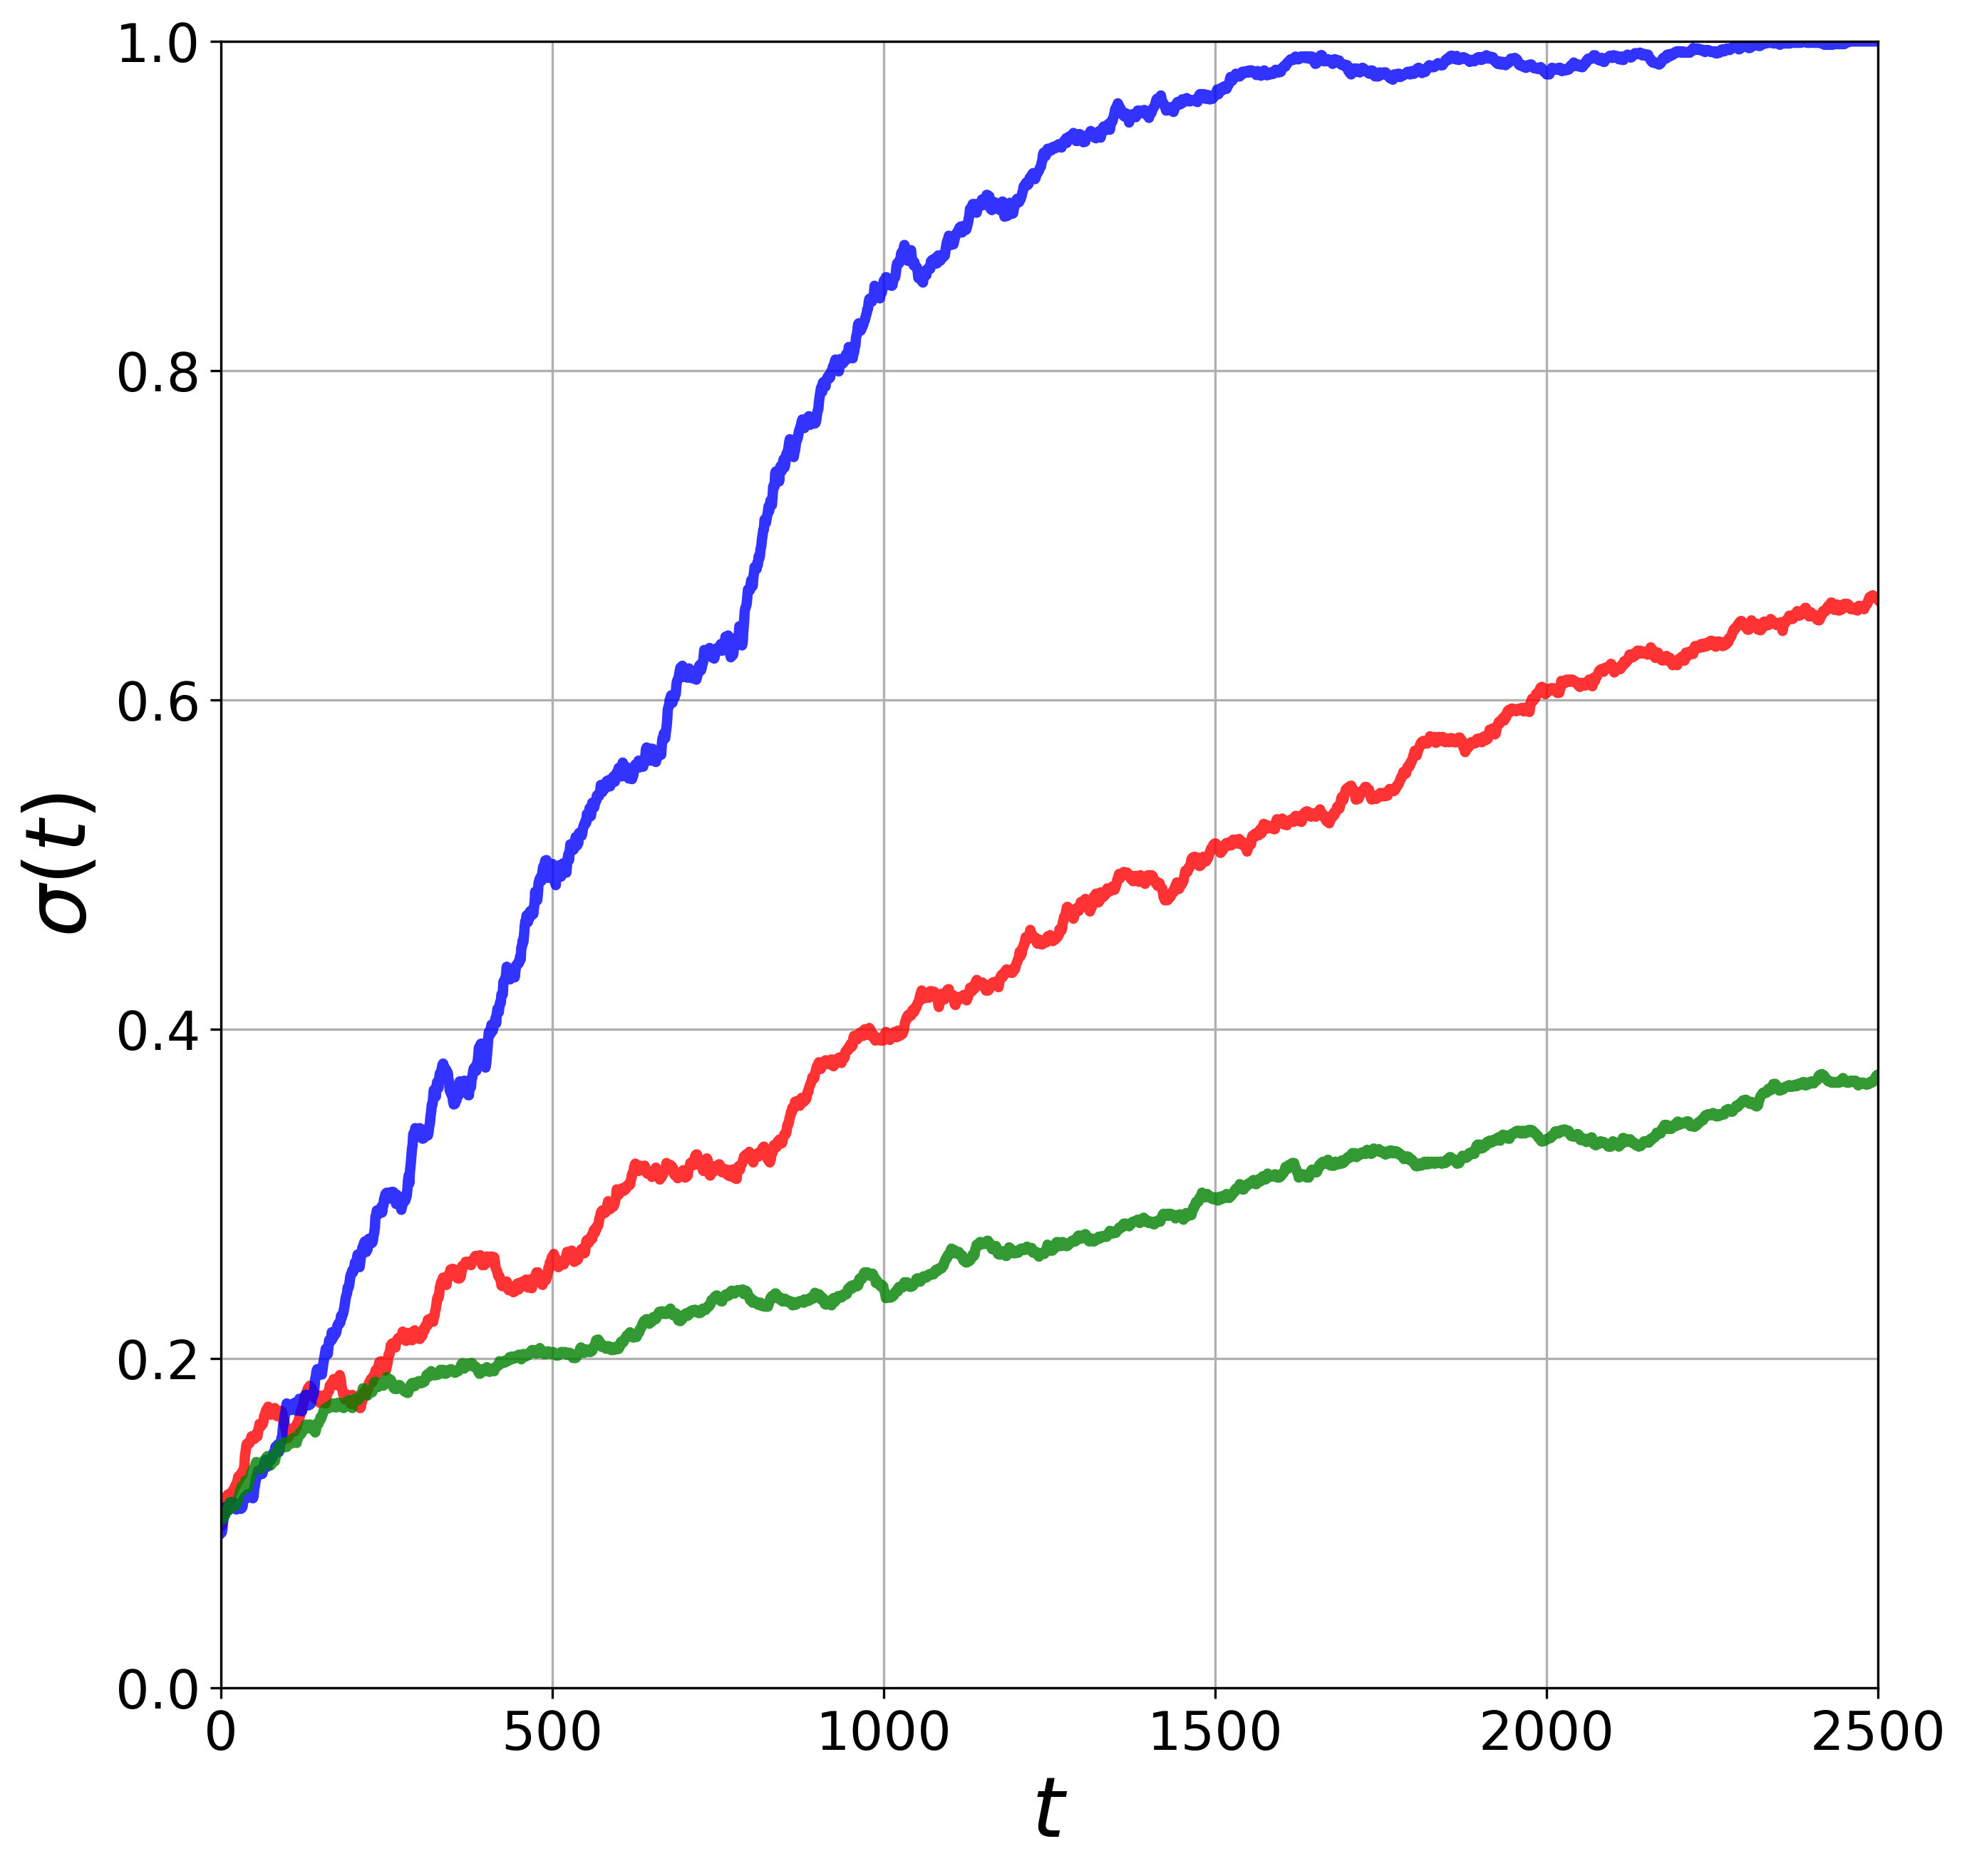

In [15]:
statics = [
    False,
    True
]

func_types = [
    FunctionType.linear,
    FunctionType.longstep
]

nums_edges = [
    1100,
    2300,
    6020
]

sdb = SimulationDatabase(path='output')
for static in statics:
    for func_type in func_types:
        for num_edges in nums_edges:
            
            sdirs = [
                sdir
                for sdir in sdb.sdirs
                if (sdir.sim.func_type == func_type) and
                (static is isinstance(sdir.sim, StaticSimulation)) and
                (num_edges - 200 <= sdir.sim.graph.graph.number_of_edges() <= num_edges + 200) and
                (sdir.sim.graph.graph_type != GraphType.complete)
            ]
            if len(sdirs) != 3:
                raise RuntimeError(f"Expected 3 SimulationDirectories after filter, got {len(sdirs)}.")
            
            sim = sdirs[1].sim
            fname = f"{sim.func_type}_e{sim.graph.graph.number_of_edges()}" + "_static" * static + ".png"
            print(f"{fname}:")
            splot = SigmaPlot(linewidth=3.5, alpha=.8, ax_tick_size=18, ax_label_size=28)
            
            gc.collect()
            
            for sdir in sdirs:
                print(f'caching {sdir}...')
                sdir.cache()
            print()
            x_max = max([sdir.t_max for sdir in sdirs])
            
            for sdir in sdirs:
                splot.plot(sdir, color=color[sdir.sim.graph.graph_type], x_max=x_max, label=label[sdir.sim.graph.graph_type])
            xright = 2500 if static else x_right[sim.func_type]
            splot.update_axlims(x_right=xright)

            # display
            display(splot.fig)

            # # save
            # splot.fig.savefig(
            #     os.path.join('plots', fname),
            #     bbox_inches='tight',
            #     pad_inches=0
            # )

## Plot three

In [17]:
num_edges = 6020
sdb = SimulationDatabase(path='output')
sdirs = [
    sdir
    for sdir in sdb.sdirs
    if sdir.sim.func_type == FunctionType.linear and
    not isinstance(sdir.sim, StaticSimulation) and
    num_edges - 70 <= sdir.sim.graph.graph.number_of_edges() <= num_edges + 70 and
    sdir.sim.graph.graph_type != GraphType.complete
]
print(sdirs)
for sdir in sdirs:
    sdir.cache()

[SimulationDirectory_linear_ring_e6000_run5, SimulationDirectory_linear_er_e6020_run5]


In [18]:
%%capture
x_max = max([sdir.t_max for sdir in sdirs])
splot = SigmaPlot(linewidth=3.5, alpha=.8, ax_tick_size=18, ax_label_size=28)
# splot.x_label = "время"
# splot.y_label = "доля вершин в состоянии 1"
# splot._setup()
for sdir in sdirs:
    splot.plot(sdir, color=color[sdir.sim.graph.graph_type], x_max=x_max)
splot.update_axlims(x_right=2500)

### Display

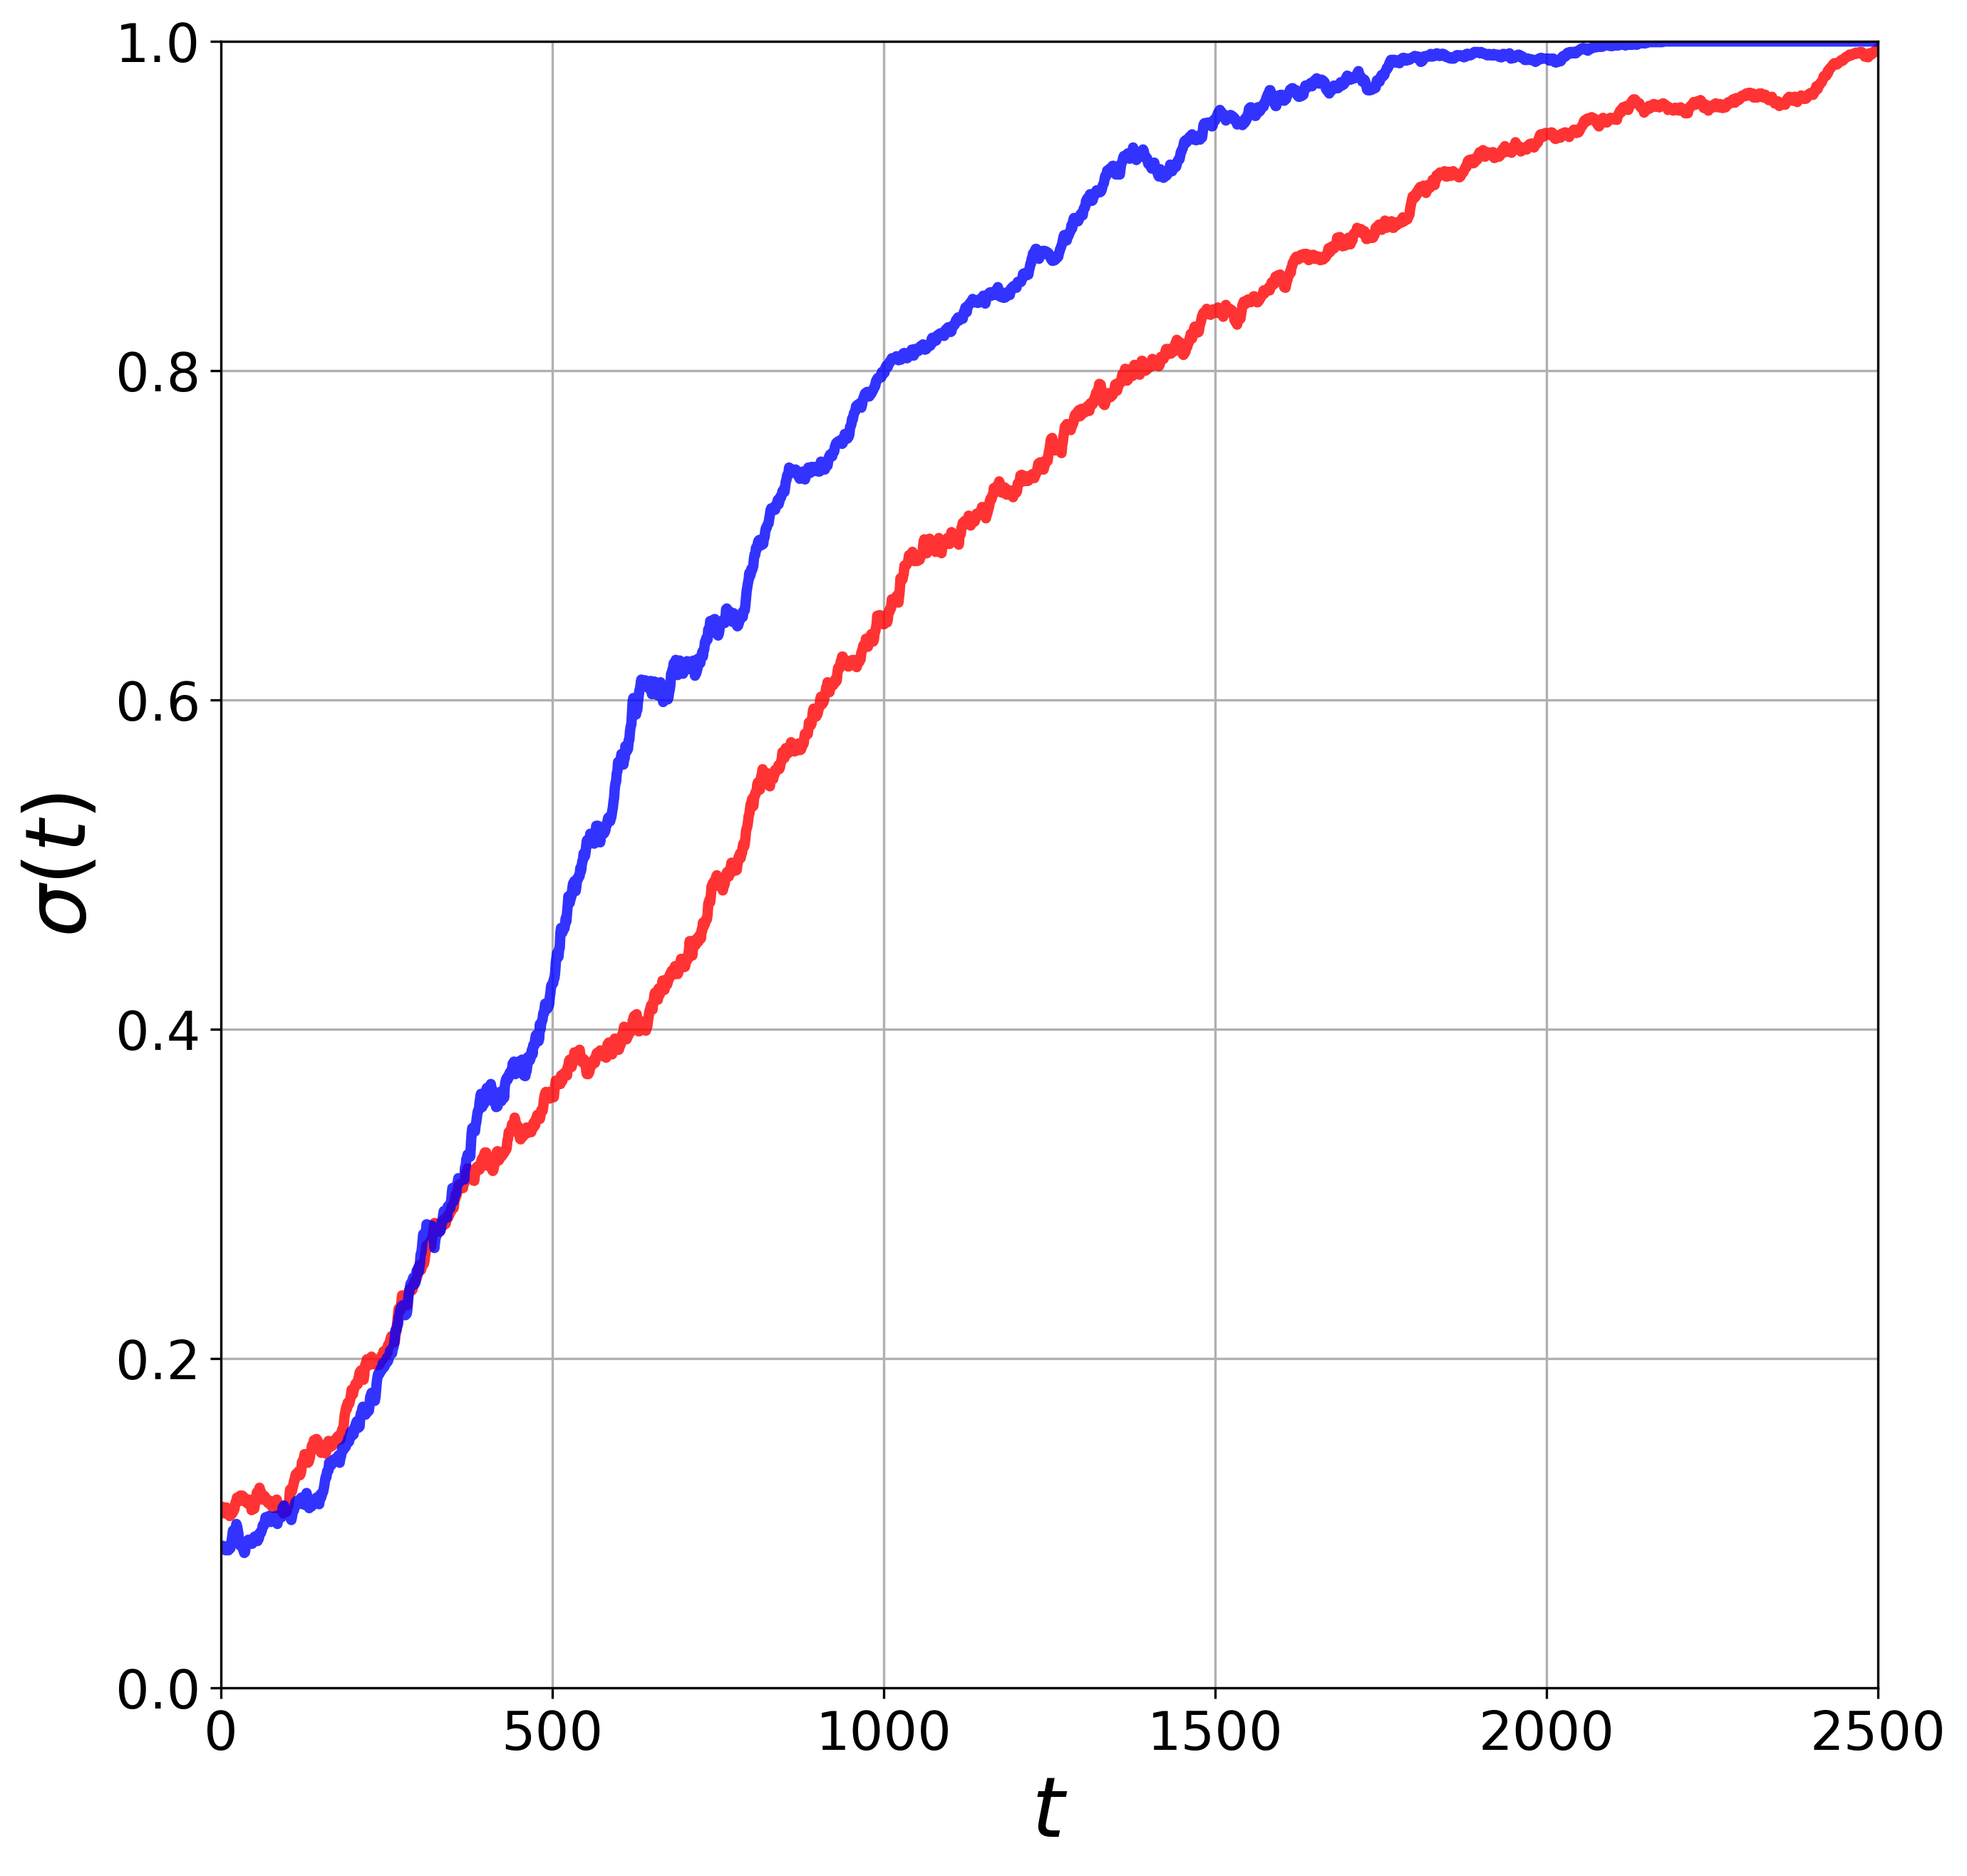

In [19]:
display(splot.fig)

### Save

In [20]:
splot.fig.savefig(
    os.path.join('plots', fname),
    bbox_inches='tight',
    pad_inches=0
)

## Animate

In [30]:
sdir = SimulationDirectory("output\\2024.04.30_14.18.48_linear_ring(n=500,k=4)_static")
sr = read_pickled('2', path=sdir.path)
animate(
    sdir.sim,
    sr,
    filename='test',
    path=sdir.path,
    t_start=max(0, sr.t - 1000),
    t_end=sr.t,
    overwrite=True
)

Converting fig2img: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.49it/s]
